In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import dask
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from utils import loca_gard_mapping
from utils import roar_data_path as project_data_path
import obs_utils as ou

In [12]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

# Observational comparison

In [40]:
import importlib
importlib.reload(ou)

<module 'obs_utils' from '/storage/work/dcl5300/current_projects/conus_comparison_lafferty-etal-2024/src/obs_utils.py'>

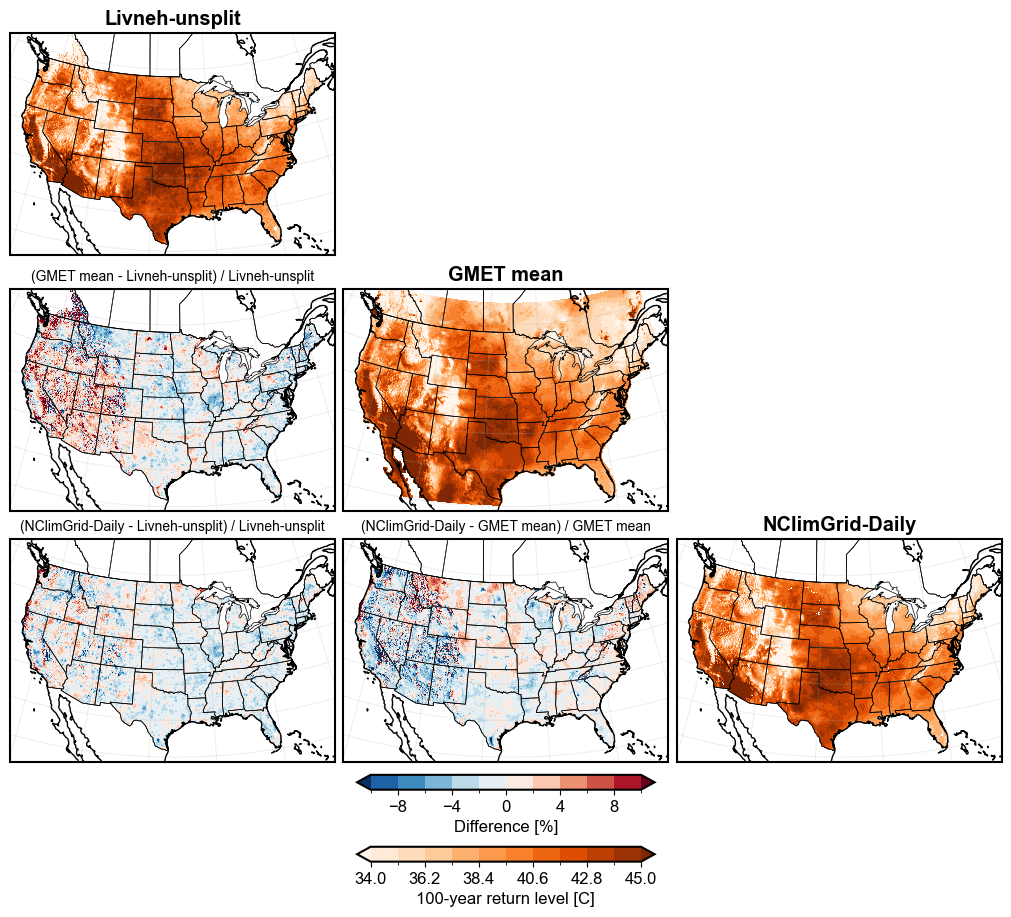

In [41]:
# max tasmax
metric_id = 'max_tasmax'
ds_livneh, ds_gmet_mean, ds_nclim = ou.read_all_obs(metric_id)

ou.plot_dataset_comparison(ds_livneh, ds_gmet_mean, ds_nclim, '100yr_return_level', 'C', cmap='Oranges', diff_lim=10)

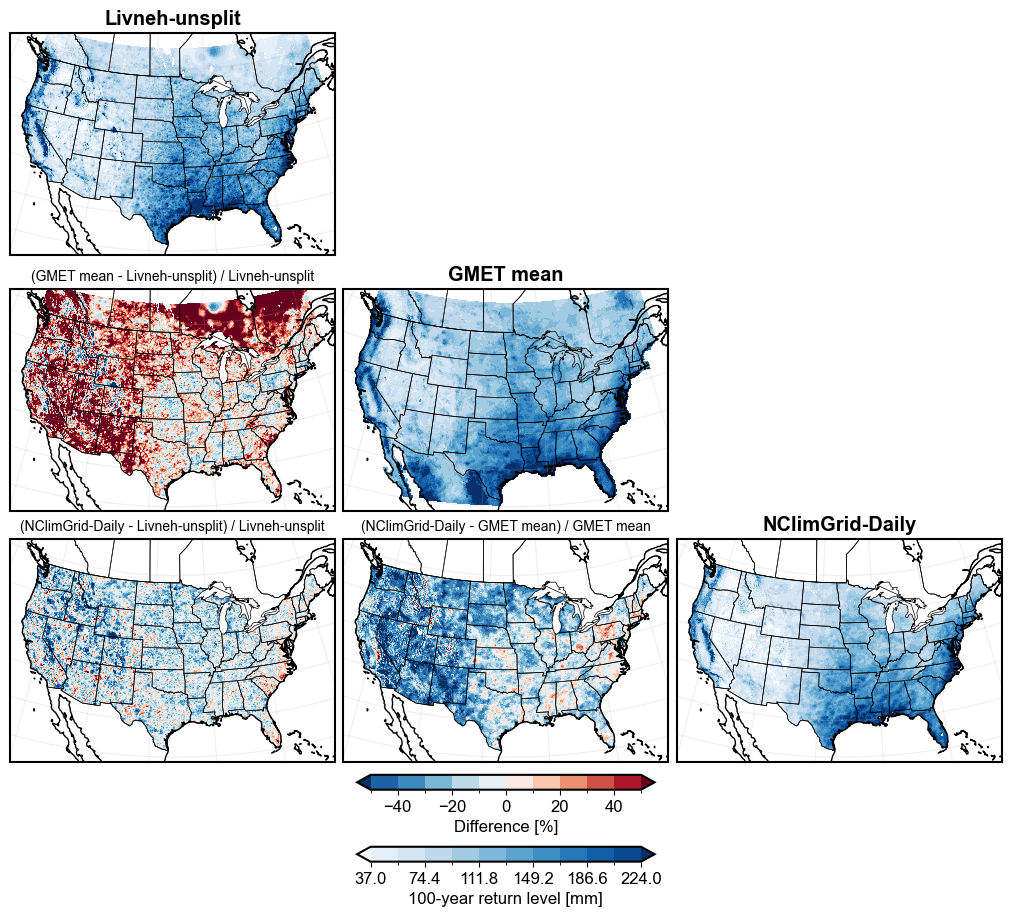

In [44]:
# max pr
metric_id = 'max_pr'
ds_livneh, ds_gmet_mean, ds_nclim = ou.read_all_obs(metric_id)

ou.plot_dataset_comparison(ds_livneh, ds_gmet_mean, ds_nclim, '100yr_return_level', 'mm', cmap='Blues', diff_lim=50)

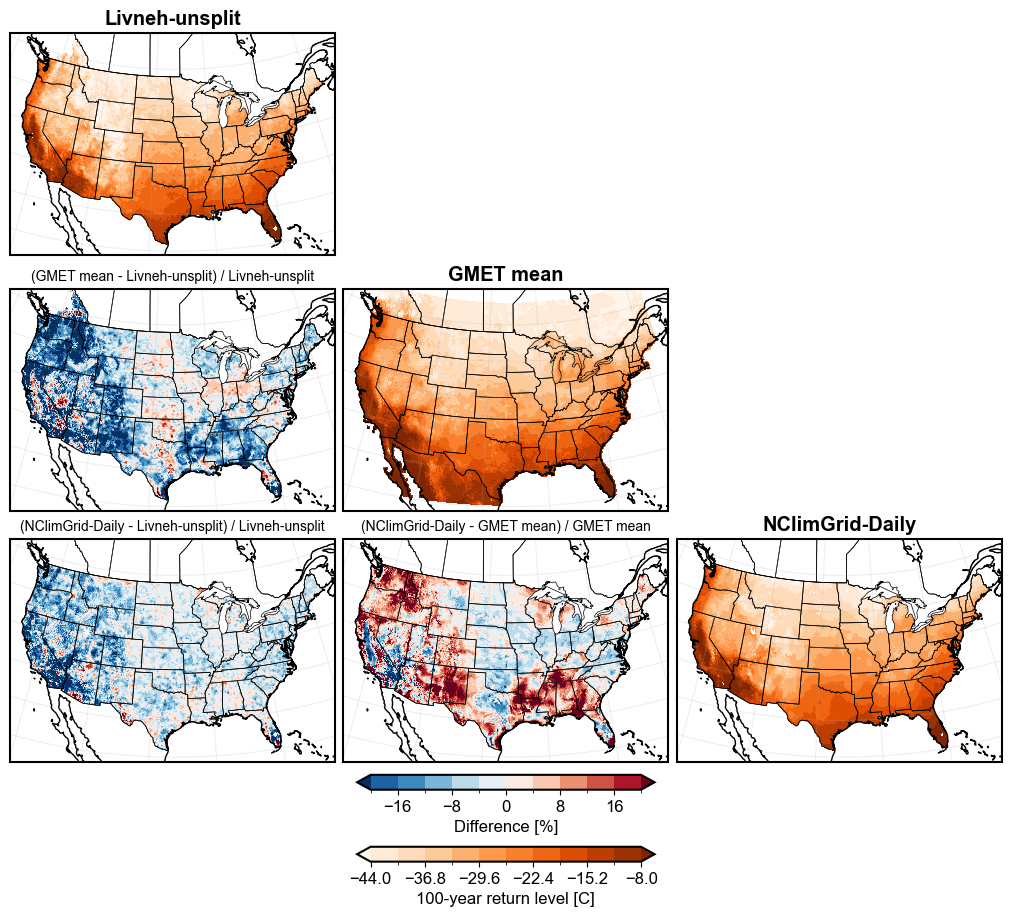

In [43]:
# min tasmin
metric_id = 'min_tasmin'
ds_livneh, ds_gmet_mean, ds_nclim = ou.read_all_obs(metric_id)

ou.plot_dataset_comparison(ds_livneh, ds_gmet_mean, ds_nclim, '100yr_return_level', 'C', cmap='Oranges', diff_lim=20)

# Maxima of raw outputs

## LOCA2

In [47]:
# LOCA2
metric_id = "max_tasmax"
loca_files_all = glob(f"{project_data_path}/metrics/LOCA2/{metric_id}_*")

In [48]:
%%time
ds = xr.concat([xr.open_dataset(file).max(dim='time').assign_coords(file = i) for i, file in enumerate(loca_files_all)], dim='file')

CPU times: user 20.6 s, sys: 39.2 s, total: 59.8 s
Wall time: 2min 3s


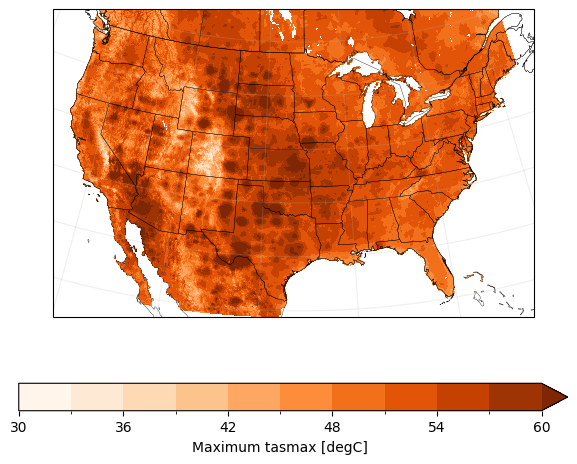

In [52]:
# Plot raw
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.LambertConformal()))
ds.max(dim='file')['tasmax'].plot(cmap="Oranges", ax=ax, 
                                  vmin=30, vmax=60, levels=11,
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=True, 
                                  cbar_kwargs={"orientation": "horizontal",
                                              "shrink": 0.9,
                                              "label": "Maximum tasmax [degC]"}
                                 )

gl = ax.gridlines(draw_labels=False, x_inline=False, rotate_labels=False, alpha=0.2)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.25)
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.25)
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.25)
ax.set_extent([-120, -73, 22, 51], ccrs.Geodetic())
plt.tight_layout()
plt.show()

## STAR-ESDM

In [2]:
# STAR-ESDM
metric_id = "max_tasmax"
star_files_all = glob(f"{project_data_path}/metrics/STAR-ESDM/{metric_id}_*")

In [3]:
# Drop TaiESM1
star_files_all = [file for file in star_files_all if "TaiESM1" not in file]

In [4]:
%%time
ds = xr.concat([xr.open_dataset(file).max(dim='time').assign_coords(file = i) for i, file in enumerate(star_files_all)], dim='file')

CPU times: user 4.14 s, sys: 15 s, total: 19.2 s
Wall time: 36 s


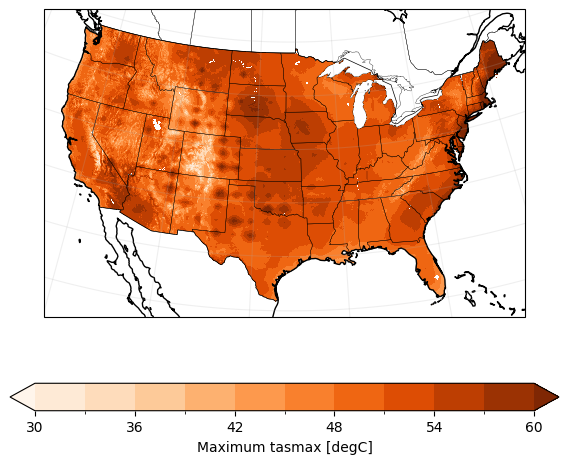

In [22]:
# Plot raw
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.LambertConformal()))
ds.max(dim='file')['tasmax'].plot(cmap="Oranges", ax=ax, levels=11,
                                  vmin=30, vmax=60,
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=True, 
                                  cbar_kwargs={"orientation": "horizontal",
                                              "shrink": 0.9,
                                              "label": "Maximum tasmax [degC]"}
                                 )

gl = ax.gridlines(draw_labels=False, x_inline=False, rotate_labels=False, alpha=0.2)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.25)
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)
# ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.5)
ax.coastlines()
ax.set_extent([-120, -73, 22, 51], ccrs.Geodetic())
plt.tight_layout()
plt.show()

# CESM naming conventions

In [2]:
# We want to check these mappings are valid
# i.e. that LOCA r1i1p1f1 and GARD-LENS 1001_01
# are downscaled from the same coarse GCM outputs.
loca_gard_mapping

{'r1i1p1f1': '1001_01',
 'r2i1p1f1': '1021_02',
 'r3i1p1f1': '1041_03',
 'r4i1p1f1': '1061_04',
 'r5i1p1f1': '1081_05',
 'r6i1p1f1': '1101_06',
 'r7i1p1f1': '1121_07',
 'r8i1p1f1': '1141_08',
 'r9i1p1f1': '1161_09',
 'r10i1p1f1': '1181_10'}

In [3]:
# Define large enough area common to both domains
lat_domain = [25,45]
lon_domain = [-125, -70]

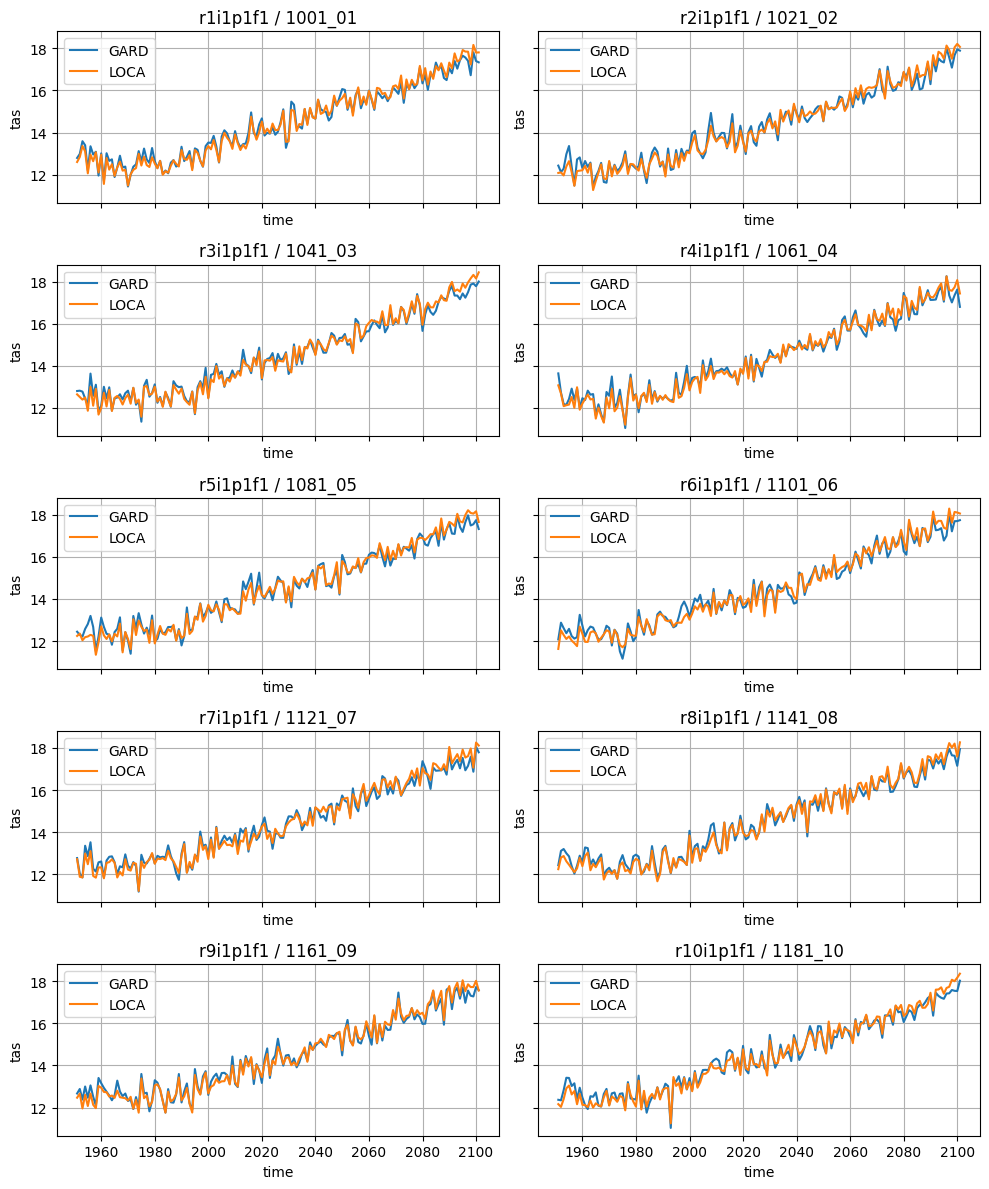

In [57]:
# Average temperature
metric_id = 'avg_tas'
var_id = 'tas'

fig, axs = plt.subplots(5, 2, figsize=(10,12), sharex=True, sharey=True)
axs = axs.flatten()

for idm, member in enumerate(loca_gard_mapping.keys()):
    ax = axs[idm]
    # Read
    ds_loca = xr.open_mfdataset(f'{project_data_path}/metrics/LOCA2/{metric_id}_CESM2-LENS_{member}_*.nc')
    ds_gard = xr.open_dataset(f'{project_data_path}/metrics/GARD-LENS/{metric_id}_cesm2_{loca_gard_mapping[member]}_ssp370.nc')

    # Plot GARD
    ds_gard[var_id].sel(lat=slice(lat_domain[0], lat_domain[1]), 
                       lon=slice(lon_domain[0], lon_domain[1])).mean(dim=['lat', 'lon']).plot(ax=ax, label='GARD')

    # Plot LOCA
    ds_loca[var_id].sel(lat=slice(lat_domain[0], lat_domain[1]), 
                       lon=slice(360+lon_domain[0], 360+lon_domain[1])).mean(dim=['lat', 'lon']).plot(ax=ax, label='LOCA')

    # Tidy
    ax.legend()
    ax.grid()
    ax.set_title(f'{member} / {loca_gard_mapping[member]}')

plt.tight_layout()
plt.show()

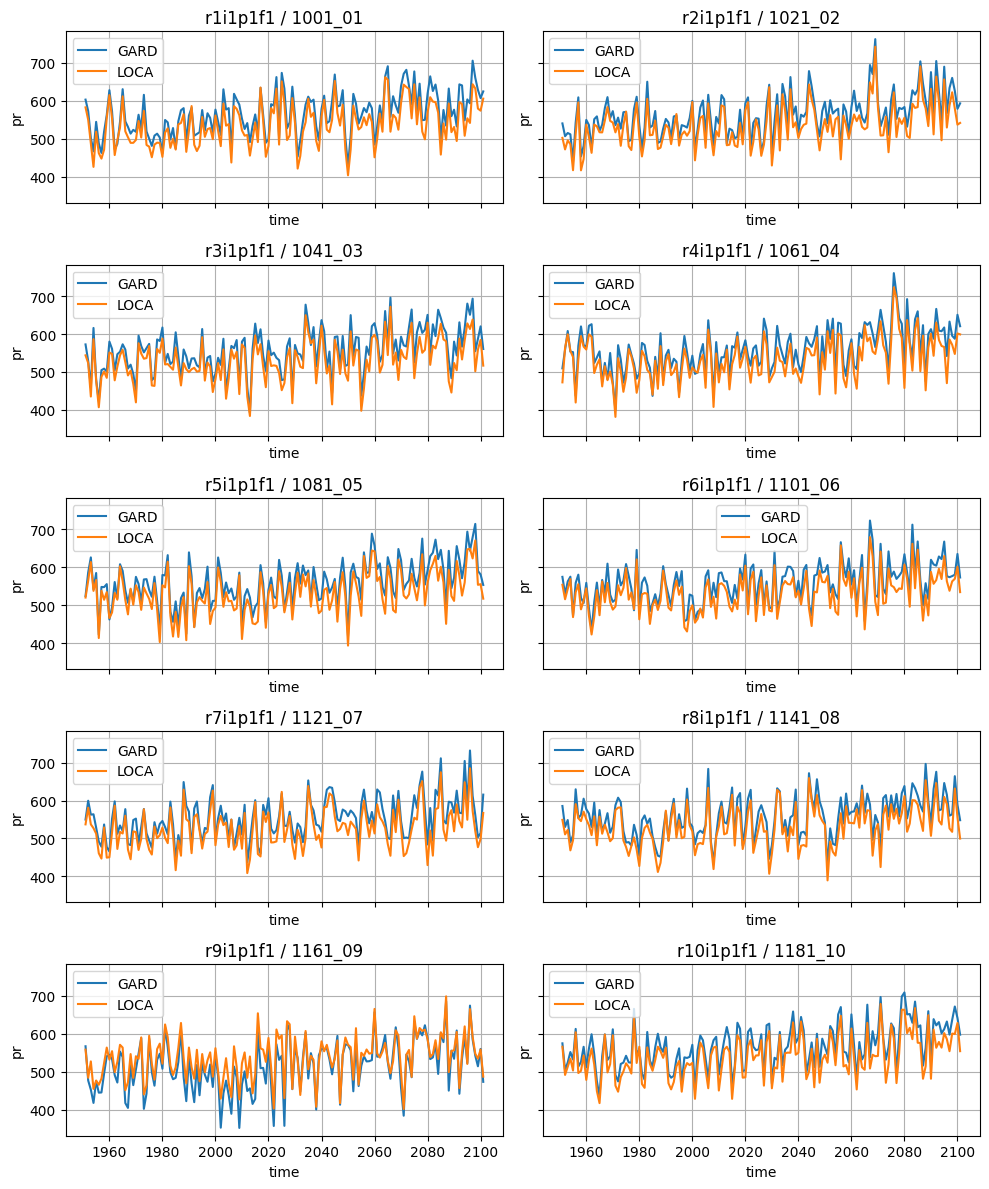

In [6]:
# Total precip
metric_id = 'sum_pr'
var_id = 'pr'

fig, axs = plt.subplots(5, 2, figsize=(10,12), sharex=True, sharey=True)
axs = axs.flatten()

for idm, member in enumerate(loca_gard_mapping.keys()):
    ax = axs[idm]
    # Read
    ds_loca = xr.open_mfdataset(f'{project_data_path}/metrics/LOCA2/{metric_id}_CESM2-LENS_{member}_*.nc')
    ds_gard = xr.open_dataset(f'{project_data_path}/metrics/GARD-LENS/{metric_id}_cesm2_{loca_gard_mapping[member]}_ssp370.nc')

    # Plot GARD
    ds_gard[var_id].sel(lat=slice(lat_domain[0], lat_domain[1]), 
                       lon=slice(lon_domain[0], lon_domain[1])).mean(dim=['lat', 'lon']).plot(ax=ax, label='GARD')

    # Plot LOCA
    ds_loca[var_id].sel(lat=slice(lat_domain[0], lat_domain[1]), 
                       lon=slice(360+lon_domain[0], 360+lon_domain[1])).mean(dim=['lat', 'lon']).plot(ax=ax, label='LOCA')

    # Tidy
    ax.legend()
    ax.grid()
    ax.set_title(f'{member} / {loca_gard_mapping[member]}')

plt.tight_layout()
plt.show()